# Fraud Detection

Tinkering with various classification models for learning purposes

In [1]:
import pandas as pd
import pandas_profiling 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
def print_confusion_matrix(confusion_matrix, class_names, figsize=(8, 5), fontsize=18):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='YlGnBu')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
#     return fig

In [3]:
cc_df = pd.read_csv("data/creditcard.csv")

print(cc_df.shape)
display(cc_df.head())

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Get the EDA report of the dataset and use it to guide some decisions
# pandas_profiling.ProfileReport(cc_df)

**Some observations based on the report above**
* There are 1080 duplicates that will need to be dropped.
* There is no missing data.
* Many of the V* features are left/right skewed and will need to be rescaled to smooth the distribution.
* The *Time* and *Amount* variables have not been scaled to match the rest of the data.
* The class or target feature is very imbalanced.
    * Specifically 0.2% is the positive (1) class and the remaining 99.8% is the negative (0) class.
    * Since most of the transactions are not fraud, it will be important to choose a model and metric that detects the patterns of the fraud (positive) class and maximizes the true positive rate.
    

In [5]:
# drop duplicates
cc_df.drop_duplicates(inplace=True)
print(cc_df.shape)

(283726, 31)


**Split the data into Train/Test sets**

In [6]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

X = cc_df.drop('Class', axis=1)
y = cc_df['Class']

spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in spliter.split(X, y):    
    train_valid_df = cc_df.iloc[train_idx]
    test_df = cc_df.iloc[test_idx]

X2 = train_valid_df.drop('Class', axis=1)
y2 = train_valid_df['Class']

for train_idx, valid_idx in spliter.split(X2, y2):
    train_df = train_valid_df.iloc[train_idx]
    valid_df = train_valid_df.iloc[valid_idx]    
    
# verify that the test split contains the same proportion of positive class values
print('Original','\n', cc_df['Class'].value_counts(normalize=True))
print('Train','\n', train_df['Class'].value_counts(normalize=True))  
print('Validation', '\n', valid_df['Class'].value_counts(normalize=True))
print('Test', '\n', test_df['Class'].value_counts(normalize=True))

Original 
 0    0.998333
1    0.001667
Name: Class, dtype: float64
Train 
 0    0.998337
1    0.001663
Name: Class, dtype: float64
Validation 
 0    0.998326
1    0.001674
Name: Class, dtype: float64
Test 
 0    0.998326
1    0.001674
Name: Class, dtype: float64


### Scaling the data

In [7]:
# Scale features using statistics that are robust to outliers.
# This Scaler removes the median and scales the data according to
# the quantile range (defaults to IQR: Interquartile Range)
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

train_df['scaled_time'] = robust_scaler.fit_transform(train_df['Time'].values.reshape(-1,1))
train_df['scaled_amount'] = robust_scaler.fit_transform(train_df['Amount'].values.reshape(-1,1))
train_df.drop(['Time', 'Amount'], axis=1, inplace=True)

valid_df['scaled_time'] = robust_scaler.fit_transform(valid_df['Time'].values.reshape(-1,1))
valid_df['scaled_amount'] = robust_scaler.fit_transform(valid_df['Amount'].values.reshape(-1,1))
valid_df.drop(['Time', 'Amount'], axis=1, inplace=True)

test_df['scaled_time'] = robust_scaler.fit_transform(test_df['Time'].values.reshape(-1,1))
test_df['scaled_amount'] = robust_scaler.fit_transform(test_df['Amount'].values.reshape(-1,1))
test_df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [8]:
X_train, y_train = train_df.drop('Class', axis=1), train_df['Class']
X_valid, y_valid = valid_df.drop('Class', axis=1), valid_df['Class']
X_test, y_test = test_df.drop('Class', axis=1), test_df['Class']

X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_time,scaled_amount
135251,-4.668495,3.932560,-0.343116,-2.199315,-1.041493,-0.859191,0.119151,0.567686,2.825739,4.016222,...,-0.465558,-0.320141,0.194736,0.057258,0.352072,0.736281,0.991712,0.513882,-0.043533,-0.259659
112506,-1.193228,-0.067069,0.195100,-0.797864,-2.724207,2.082131,2.237805,0.279369,0.186022,-1.367085,...,-0.077393,-0.077975,0.425741,-0.743803,-0.710705,0.689694,0.110856,-0.047984,-0.143342,8.201080
129491,-2.139337,-0.477542,1.023329,0.553691,-0.760199,-0.079801,-0.250863,0.230727,-0.971462,0.726832,...,-0.350356,0.261436,0.228479,-0.074661,0.097454,-0.133517,0.282959,-0.037037,-0.067774,1.347320
220399,1.473130,-0.771461,-1.935011,1.648650,0.002056,-1.161882,0.969145,-0.457524,0.339598,0.164073,...,0.208218,0.105906,-0.250718,0.035859,0.326683,-0.522441,-0.080269,-0.013062,0.673364,3.846974
86546,0.874556,0.028103,0.949206,2.427185,-0.346842,0.522520,-0.251504,0.242281,-0.755448,0.743199,...,0.257700,0.494448,-0.117962,0.021798,0.276067,0.069338,0.006406,0.035184,-0.277349,1.215206


### Creating a baseline model using Logistic Regression
This classes here are very imbalanced

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, precision_score, confusion_matrix

def log_reg_results(X_train, y_train, X_valid, y_valid):
    log_reg = LogisticRegression(solver='liblinear', penalty='l1', C=1.0)
    log_reg.fit(X_train, y_train)
    log_reg_predictions = log_reg.predict(X_valid)

    log_reg_recall = recall_score(y_valid, log_reg_predictions)
    log_reg_f1_score = f1_score(y_valid, log_reg_predictions)
    log_reg_precision = precision_score(y_valid, log_reg_predictions)
    log_reg_conf_mat = confusion_matrix(y_valid, log_reg_predictions)
    print('F1 score: ', log_reg_f1_score)
    print('Recall: ', log_reg_recall)
    print('Precision: ', log_reg_precision)
    return log_reg_conf_mat

F1 score:  0.7727272727272728
Recall:  0.6710526315789473
Precision:  0.9107142857142857


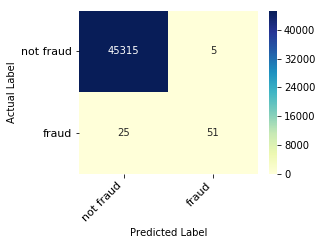

In [10]:
cm = log_reg_results(X_train, y_train, X_valid, y_valid)    
print_confusion_matrix(cm, ['not fraud', 'fraud'], figsize=(4, 3), fontsize=11)

# Make an effort to balance out the classes using various techniques
* Under-Sampling Techniques
    * Random

* Over-Sampling Techniques
    * Random
    * SMOTE

### Random Under-Sampling
* Randomly sample the negative class to match the number of instances in the positive class
* Risk of loosing valuable infomation in training

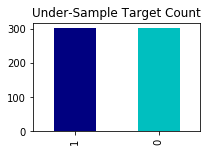

In [11]:
from sklearn.utils import resample

fraud = train_df[train_df['Class'] == 1]
not_fraud = train_df[train_df['Class'] == 0]

undersample_not_fraud = resample(not_fraud, replace=False, n_samples=len(fraud), random_state=11)
train_df_undersampled = pd.concat([fraud, undersample_not_fraud], axis=0).sample(frac=1)

# confirm the classes are balances
(train_df_undersampled['Class'].value_counts()
     .plot(kind='bar', figsize=(3,2), title='Under-Sample Target Count', color=['navy', 'c']));

F1 score:  0.05426661423515533
Recall:  0.9078947368421053
Precision:  0.027969193352249695


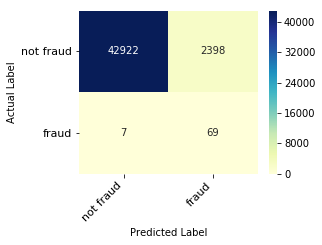

In [12]:
# get scores of Log Reg from from undersampled set
X = train_df_undersampled.drop('Class', axis=1)
y = train_df_undersampled['Class']
cm = log_reg_results(X, y, X_valid, y_valid)
print_confusion_matrix(cm, ['not fraud', 'fraud'], figsize=(4, 3), fontsize=11)

**NOTES**
* Precision and F1 significantly decreased, however recall inceased.  
* In fraud detection, having a higher recall is more important. 

### Random Over-Sampling
* Repeatedly sample the positive class until the number of instances are equal in both.
* Risk of overfitting to the positive class

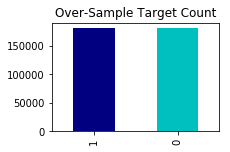

In [13]:
fraud = train_df[train_df['Class'] == 1]
not_fraud = train_df[train_df['Class'] == 0]

oversample_fraud = resample(fraud, replace=True, n_samples=len(not_fraud), random_state=11)
train_df_oversampled = pd.concat([not_fraud, oversample_fraud], axis=0).sample(frac=1)

# confirm the classes are balanced
(train_df_oversampled['Class'].value_counts()
     .plot(kind='bar', figsize=(3,2), title='Over-Sample Target Count', color=['navy', 'c']));

F1 score:  0.09977989728539985
Recall:  0.8947368421052632
Precision:  0.05283605283605284


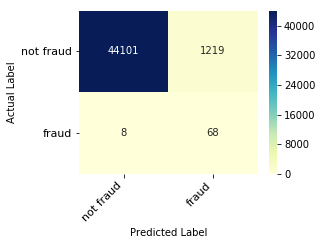

In [14]:
# get scores of Log Reg from from oversampled set
X = train_df_oversampled.drop('Class', axis=1)
y = train_df_oversampled['Class']
cm = log_reg_results(X, y, X_valid, y_valid)
print_confusion_matrix(cm, ['not fraud', 'fraud'], figsize=(4, 3), fontsize=11)

**NOTES**
* Precision and F1 score is slightly increased from under-sampling, recall remained the same. 
* Over-sampling yielded a better result than under-sampling.

### SMOTE Over-Sampling
* SMOTE (Synthetic Minority Oversampling TEchnique)
* Consists of synthesizing elements for the minority class, based on those that already exist. 
* It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. 
* The synthetic points are added between the chosen point and its neighbors.

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_smote, y_smote = smote.fit_sample(X_train, y_train)

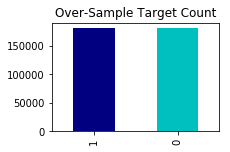

In [16]:
y_smote = pd.Series(y_smote)
(y_smote.value_counts()
     .plot(kind='bar', figsize=(3,2), title='Over-Sample Target Count', color=['navy', 'c']));

F1 score:  0.09630146545708304
Recall:  0.9078947368421053
Precision:  0.05084745762711865


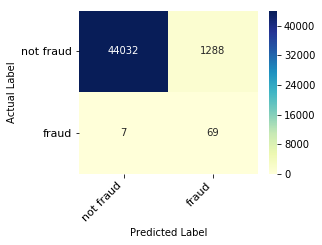

In [17]:
cm = log_reg_results(X_smote, y_smote, X_valid, y_valid)
print_confusion_matrix(cm, ['not fraud', 'fraud'], figsize=(4, 3), fontsize=11)

**NOTES:** 
The results are relatively the same as random over-sampling with vert slight changes in the F1 and precision scores.  The recall remained the same. 

## Upgrade the classifier
Now that it is apparent which sampling method **(Random over-sampling)** performs best on a classifier, lets see if changing to a more complex classifier makes a difference in predictive power. 

F1 score:  0.029405587061541692
Recall:  0.9210526315789473
Precision:  0.014941302027748132


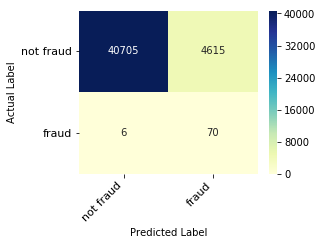

In [18]:
from sklearn.tree import DecisionTreeClassifier

X_under = train_df_undersampled.drop('Class', axis=1)
y_under = train_df_undersampled['Class']
X_over = train_df_oversampled.drop('Class', axis=1)
y_over = train_df_oversampled['Class']

dec_tree = DecisionTreeClassifier()
# dec_tree.fit(X_over, y_over)
dec_tree.fit(X_under, y_under)
dec_tree_predictions = dec_tree.predict(X_valid)

dec_tree_recall = recall_score(y_valid, dec_tree_predictions)
dec_tree_f1_score = f1_score(y_valid, dec_tree_predictions)
dec_tree_precision = precision_score(y_valid, dec_tree_predictions)
dec_tree_conf_mat = confusion_matrix(y_valid, dec_tree_predictions)

print('F1 score: ', dec_tree_f1_score)
print('Recall: ', dec_tree_recall)
print('Precision: ', dec_tree_precision)
print_confusion_matrix(dec_tree_conf_mat, ['not fraud', 'fraud'], figsize=(4, 3), fontsize=11)

## Test

F1 score:  0.09529276693455797
Recall:  0.8736842105263158
Precision:  0.050394656952034


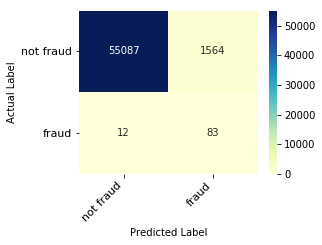

In [19]:
# Test Logistic Regression     
log_reg = LogisticRegression(solver='liblinear', penalty='l2', C=1.0)
log_reg.fit(X_over, y_over)
# log_reg.fit(X_under, y_under)
log_reg_predictions = log_reg.predict(X_test)

log_reg_recall = recall_score(y_test, log_reg_predictions)
log_reg_f1_score = f1_score(y_test, log_reg_predictions)
log_reg_precision = precision_score(y_test, log_reg_predictions)
log_reg_conf_mat = confusion_matrix(y_test, log_reg_predictions)

print('F1 score: ', log_reg_f1_score)
print('Recall: ', log_reg_recall)
print('Precision: ', log_reg_precision)
print_confusion_matrix(log_reg_conf_mat, ['not fraud', 'fraud'], figsize=(4, 3), fontsize=11)

F1 score:  0.030404808202227327
Recall:  0.9052631578947369
Precision:  0.015462064005753326


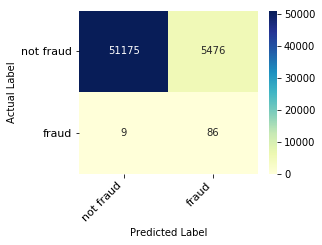

In [20]:
# Test Decision Tree Classifier
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_under, y_under)
dec_tree_predictions = dec_tree.predict(X_test)

dec_tree_recall = recall_score(y_test, dec_tree_predictions)
dec_tree_f1_score = f1_score(y_test, dec_tree_predictions)
dec_tree_precision = precision_score(y_test, dec_tree_predictions)
dec_tree_conf_mat = confusion_matrix(y_test, dec_tree_predictions)

print('F1 score: ', dec_tree_f1_score)
print('Recall: ', dec_tree_recall)
print('Precision: ', dec_tree_precision)
print_confusion_matrix(dec_tree_conf_mat, ['not fraud', 'fraud'], figsize=(4, 3), fontsize=11)

Trade-off between DT and LR.
LR performs better with over fitting data.  The flase negatives are fewer and the recall is resonably good.
DT performs better with under fitting the data.  The recall is higher, but it does come at the expence of lower precision and recall.  Large number of false positives. Also L1 regularization performs better than L2 in testing. 